**任务时间：题目1-3（11.05-11.10）
题目4、5（11.12-11.17）
题目6（11.19-11.25）**

**互评与筛选时间：题目1-3（11.11）
题目4、5（11.18）
题目6（11.26）**

每周只用提交相应的部分到自己的git，试题实行每周淘汰制

新互评链接：https://yiqixie.com/s/home/fcACT-kZRz10FXWBU2jXDt8VO

# 4、调用alpha101、alpha191、技术因子、candleresearch或者自己创造衍生因子，要求：任意两个因子，进行画图观察，主要例子看alpha101research和candleresearch，写研究报告（画了什么因子，思考了什么现象，对现象进行描述）


https://github.com/ChannelCMT/formula/wiki

数据类型和周期自定


# 因子一：alpha006

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '1H',
         'start_date':20180101000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

5.857769250869751


In [3]:
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv = HFDataView()

In [4]:
dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [5]:
import matplotlib.pyplot as plt

def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-250:])
    ax1.plot(alpha.iloc[-250:])
    # plt.savefig('good')
    plt.show()

In [51]:
#调用Alpha101中Alpha006因子，画图观察
alpha6=dv.add_formula(field_name='alpha6_C',formula='-1*Correlation(open,volume,10)',add_data=True)

Field [alpha6_C] is overwritten.


In [52]:
alpha6_plot = dv.get_ts('alpha6_C', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')

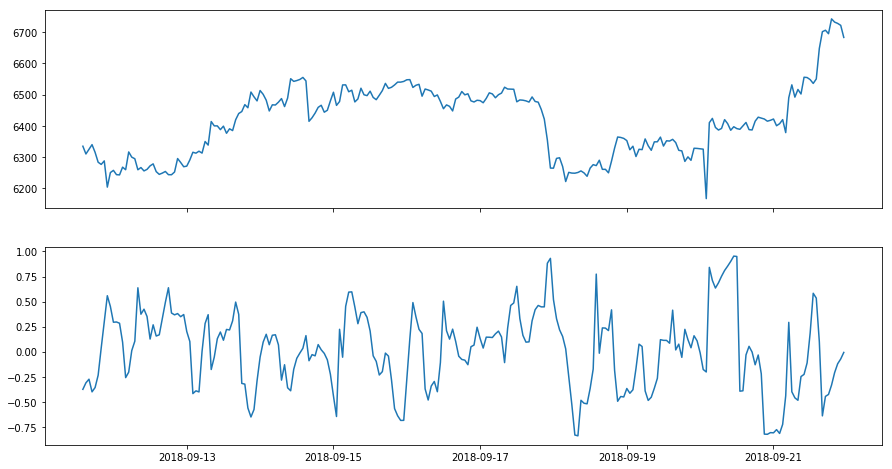

In [26]:
plot_chart(close, alpha6_plot)

观察发现Alpha006表示的是10日开盘价和成交量的相关系数，相关系数存在一定反比关系，相关系数小于-0.25时收盘价会上升，而高于0.25时，收盘价会下降

# 因子二： ROC6——6日变动速率(6-day Price Rate of Change)

In [89]:
data1H = Time_dict.set_index('datetime')

In [29]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()

In [30]:
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [88]:
ROC6 = dv.add_formula('ROC6', '((close/Delay(close, 6))-1)*100' , add_data=False)

In [90]:
ROC6_plot = dv.get_ts('ROC6', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')

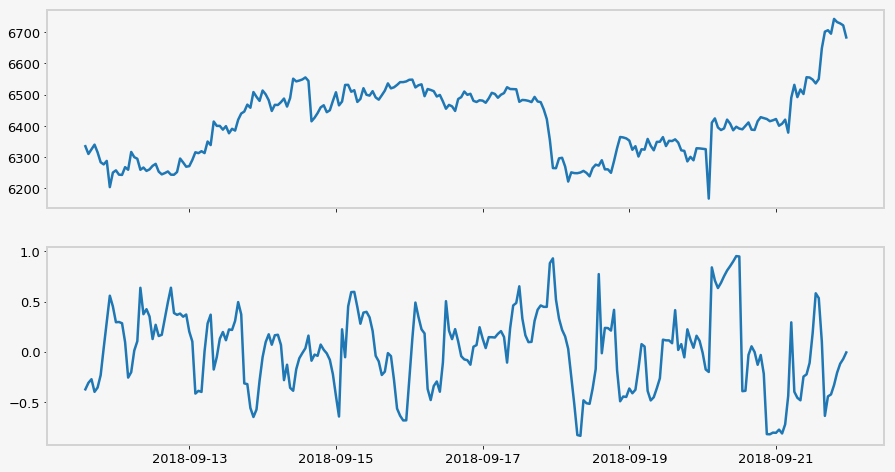

In [91]:
plot_chart(close, alpha6_plot)

画图观察发现ROC6因子和成交量之间短时间内存在一定的反比关系，ROC6小于-0.5时收盘价会上升，而高于0.5时，收盘价会下降

# 5、观察两个因子，和价格图有什么联系，如果是蜡烛图，和成交量有什么联系，怎么找到相应的信号，提出自己信号进出场的假设。（分别完成两个因子的信号假设）

信号进出场假设：可以借鉴MastatiscResearch，但不要将思路假设局限在均线上，可以观察大盘上的其他现象来写信号假设，也可以进行同时满足多个因子的信号来设计信号假设等等。

此处需要说出联系、找到的信号、你的信号进出场假设是什么

# 联系总结如下：
1.观察发现Alpha006表示的是10日开盘价和成交量的相关系数，短时间内和成交量之间存在一定反比关系，相关系数小于-0.25时收盘价会上升，而高于0.25时，收盘价会下降

进出场假设：相关系数下降到小于等于-0.25时做多，而上升到大于等于0.25时做空

2.观察发现ROC6因子和成交量之间短时间内存在一定的反比关系，ROC6小于-0.25时收盘价会上升，而高于0.25时，收盘价会下降

进出场假设：相关系数下降到小于等于-0.5时做多，而上升到大于等于0.5时做空

# 6、将你的其中一个假设落实，如果能完成两个更好，但不强求

利用TimingSignal最后输出long、short、long_short这三个绩效表出来

# Alpha006相关系数下降到小于等于-0.25时做多，而上升到大于等于0.25时做空

In [112]:
#Alpha006做多做空信号
long = dv1H.add_formula('long','If(((-1*Correlation(open,volume,10))<=-0.25) && (Delay((-1*Correlation(open,volume,10)),1)>-0.25), 2, 0)', add_data=True)
short = dv1H.add_formula('short','If(((-1*Correlation(open,volume,10))>=0.25) && (Delay((-1*Correlation(open,volume,10)),1)>0.25), -2, 0)', add_data=True)
closeLong = dv1H.add_formula('closeLong','If(short==-2,1,0)', add_data=True)
closeShort = dv1H.add_formula("closeShort",'If(long==2,-1,0)', add_data=True)

Field [long] is overwritten.
Field [short] is overwritten.
Field [closeLong] is overwritten.
Field [closeShort] is overwritten.


In [111]:
from jaqs_fxdayu.research import TimingDigger

tdAlpha6 = TimingDigger(output_folder=".", output_format='pdf',signal_name='MaStatistic')

def TimingSignal(td, dv, mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称


    #多空分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts("long"),
        exit_signal=dv.get_ts("closeLong"),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts("short"),
        exit_signal=dv.get_ts("closeShort"),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdAlpha6, dv1H, 100, 0.15, 0.7)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 4%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 8%


In [96]:
tdAlpha6.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               13.048  -18.130   -2.195
p-value               0.000    0.000    0.029
mean                  0.024   -0.023   -0.003
std                   0.025    0.020    0.032
info_ratio            0.962   -1.131   -0.104
skewness              1.731   -0.934    0.539
kurtosis              2.780    0.383    1.556
pct5                  0.002   -0.059   -0.054
pct25                 0.006   -0.036   -0.023
pct50                 0.015   -0.016   -0.003
pct75                 0.030   -0.006    0.012
pct95                 0.085   -0.001    0.047
occurance           185.000  258.000  443.000
win_ratio               NaN      NaN    0.418
win_mean/loss_mean      NaN      NaN    1.044


In [97]:
tdAlpha6.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                        win     loss       all
t-stat               22.811  -22.934     1.577
p-value               0.000    0.000     0.115
mean                  0.033   -0.023     0.002
std                   0.036    0.028     0.042
info_ratio            0.902   -0.813     0.042
skewness              1.767   -2.589     0.394
kurtosis              3.102    9.028     3.958
pct5                  0.001   -0.077    -0.059
pct25                 0.006   -0.032    -0.015
pct50                 0.020   -0.012    -0.002
pct75                 0.049   -0.005     0.016
pct95                 0.110   -0.001     0.073
occurance           641.000  797.000  1438.000
win_ratio               NaN      NaN     0.446
win_mean/loss_mean      NaN      NaN     1.415


In [98]:
tdAlpha6.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win      loss       all
t-stat               25.782   -28.080     0.602
p-value               0.000     0.000     0.547
mean                  0.031    -0.023     0.001
std                   0.034     0.027     0.040
info_ratio            0.898    -0.865     0.014
skewness              1.855    -2.473     0.448
kurtosis              3.618     9.030     4.002
pct5                  0.001    -0.071    -0.057
pct25                 0.006    -0.034    -0.016
pct50                 0.020    -0.013    -0.002
pct75                 0.043    -0.005     0.014
pct95                 0.104    -0.001     0.067
occurance           826.000  1055.000  1881.000
win_ratio               NaN       NaN     0.439
win_mean/loss_mean      NaN       NaN     1.333


考虑到occurance,win_ratio,win_mean/loss_mean,算出来win期望总值大于loss期望总值，因子表现良好

# ROC6下降到小于等于-0.5时做多，而上升到大于等于0.5时做空

In [113]:
#ROC6做多做空信号
long = dv1H.add_formula('long','If(((((close/Delay(close, 6))-1)*100)<=-0.5) && (Delay((((close/Delay(close, 6))-1)*100),1)>-0.5), 2, 0)', add_data=True)
short = dv1H.add_formula('short','If(((((close/Delay(close, 6))-1)*100)>=0.5) && (Delay((((close/Delay(close, 6))-1)*100),1)>0.5), -2, 0)', add_data=True)
closeLong = dv1H.add_formula('closeLong','If(short==-2,1,0)', add_data=True)
closeShort = dv1H.add_formula("closeShort",'If(long==2,-1,0)', add_data=True)

Field [long] is overwritten.
Field [short] is overwritten.
Field [closeLong] is overwritten.
Field [closeShort] is overwritten.


In [115]:
from jaqs_fxdayu.research import TimingDigger

tdROC6 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Ma')

def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [116]:
TimingSignal(tdROC6, dv1H, mhp=100, sl=0.05, sp=0.3)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 8%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 25%


In [117]:
tdROC6.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               18.206  -16.872   -0.595
p-value               0.000    0.000    0.552
mean                  0.019   -0.030   -0.001
std                   0.018    0.025    0.032
info_ratio            1.031   -1.164   -0.026
skewness              2.191   -0.435   -0.362
kurtosis              6.728   -1.297    0.821
pct5                  0.001   -0.069   -0.061
pct25                 0.006   -0.055   -0.012
pct50                 0.014   -0.021    0.004
pct75                 0.024   -0.006    0.016
pct95                 0.053   -0.001    0.044
occurance           313.000  211.000  524.000
win_ratio               NaN      NaN    0.597
win_mean/loss_mean      NaN      NaN    0.627


In [118]:
tdROC6.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                        win     loss       all
t-stat               30.320  -22.544     3.840
p-value               0.000    0.000     0.000
mean                  0.016   -0.019     0.002
std                   0.016    0.021     0.025
info_ratio            0.972   -0.910     0.096
skewness              2.575   -1.291    -0.263
kurtosis             10.671    0.632     3.146
pct5                  0.001   -0.059    -0.052
pct25                 0.005   -0.026    -0.005
pct50                 0.011   -0.010     0.003
pct75                 0.021   -0.003     0.015
pct95                 0.045   -0.001     0.037
occurance           975.000  615.000  1590.000
win_ratio               NaN      NaN     0.613
win_mean/loss_mean      NaN      NaN     0.837


In [119]:
tdROC6.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                         win     loss       all
t-stat                35.279  -27.549     2.729
p-value                0.000    0.000     0.006
mean                   0.016   -0.022     0.002
std                    0.017    0.022     0.027
info_ratio             0.983   -0.959     0.059
skewness               2.467   -1.037    -0.348
kurtosis               9.440   -0.181     2.370
pct5                   0.001   -0.065    -0.055
pct25                  0.005   -0.034    -0.006
pct50                  0.012   -0.012     0.004
pct75                  0.022   -0.004     0.015
pct95                  0.047   -0.001     0.039
occurance           1288.000  826.000  2114.000
win_ratio                NaN      NaN     0.609
win_mean/loss_mean       NaN      NaN     0.762


考虑到occurance,win_ratio,win_mean/loss_mean,算出来win期望总值大于loss期望总值，因子表现良好